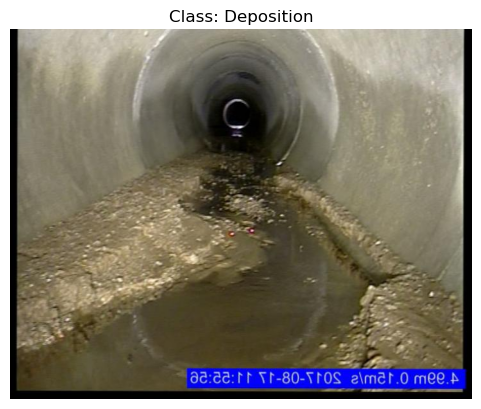

In [5]:
import os
import random
import yaml
from PIL import Image
import matplotlib.pyplot as plt

# Caminhos para os diretórios
images_path = r'Defect-detection-in-pipelines/images/images/train'
labels_path = r'Defect-detection-in-pipelines/labels/labels/train'
config_path = r'Defect-detection-in-pipelines/config.yaml'

# Carregar o arquivo de configuração
with open(config_path, 'r') as file:
    config = yaml.load(file, Loader=yaml.FullLoader)

# Mapeamento das classes
class_names = config['names']

# Obter lista de arquivos de imagens
image_files = os.listdir(images_path)

# Selecionar uma imagem aleatória
random_image = random.choice(image_files)

# Carregar a imagem usando PIL
image_path = os.path.join(images_path, random_image)
image = Image.open(image_path)

# Obter o nome do arquivo da label correspondente
label_file = random_image.replace('.jpg', '.txt')  # Ajuste conforme o formato real
label_path = os.path.join(labels_path, label_file)

# Carregar a label e extrair a classe (primeiro número da linha)
with open(label_path, 'r') as file:
    line = file.readline().strip()
    label = int(line.split()[0])  # Extrair apenas o índice da classe

# Exibir a imagem com a classificação
plt.imshow(image)
plt.title(f'Class: {class_names[label]}')
plt.axis('off')  # Desabilitar os eixos
plt.show()


Explicação do código:
Carregamento de imagens e labels: As imagens são carregadas e redimensionadas para (128, 128) usando PIL. Os labels são extraídos dos arquivos .txt e mapeados para as classes correspondentes.
Pré-processamento: A normalização é realizada para garantir que os valores dos pixels estejam no intervalo [0, 1]. O conjunto de dados é dividido em treinamento, validação e teste, com 70%, 15% e 15%, respectivamente.
Data Augmentation: Para lidar com o desbalanceamento, são aplicadas transformações como rotação, deslocamento e flip nas imagens de treino.
Modelo CNN: A arquitetura da rede consiste em camadas Conv2D para extração de características, MaxPooling2D para redução de dimensionalidade, e camadas densas para classificação final.
Treinamento: O modelo é treinado com o otimizador Adam, usando o categorical_crossentropy como função de perda. O EarlyStopping é utilizado para evitar overfitting.
Avaliação: A acurácia, o F1-score e a matriz de confusão são calculados para avaliar a performance do modelo no conjunto de teste.
Curvas de treinamento: A evolução da acurácia ao longo das épocas é plotada.
Esse código é um ponto de partida para seu modelo de CNN, que pode ser ajustado conforme necessário (por exemplo, adicionando mais camadas ou ajustando os parâmetros de treinamento).

In [1]:
from PIL import Image
import os

# Caminho das imagens
images_path = r'C:\Users\lidia\OneDrive\Área de Trabalho\Mestrado\Visão Computacional\pipeline_dataset\images\images\train'

# Obter uma lista de arquivos de imagem
image_files = os.listdir(images_path)

# Escolher uma imagem aleatória ou a primeira da lista
sample_image_path = os.path.join(images_path, image_files[0])

# Abrir a imagem
with Image.open(sample_image_path) as img:
    width, height = img.size
    print(f"Dimensões da imagem: {width}x{height} (Largura x Altura)")
    print(f"Formato: {img.format}")  # Ex: JPEG, PNG
    print(f"Modo de cor: {img.mode}")  # Ex: RGB, L



Dimensões da imagem: 720x576 (Largura x Altura)
Formato: JPEG
Modo de cor: RGB


In [2]:
dimensions = []
for image_file in image_files:
    image_path = os.path.join(images_path, image_file)
    with Image.open(image_path) as img:
        dimensions.append(img.size)

# Exibir as dimensões únicas
unique_dimensions = set(dimensions)
print(f"Dimensões únicas das imagens: {unique_dimensions}")


Dimensões únicas das imagens: {(704, 576), (511, 383), (616, 347), (625, 469), (462, 347), (400, 400), (580, 464), (520, 416), (640, 368), (608, 486), (567, 454), (509, 382), (589, 442), (609, 487), (584, 467), (789, 631), (450, 338), (640, 480), (582, 466), (720, 540), (462, 260), (875, 700), (539, 303), (320, 240), (720, 576), (480, 360), (704, 528), (518, 414), (816, 653), (640, 360), (481, 385)}


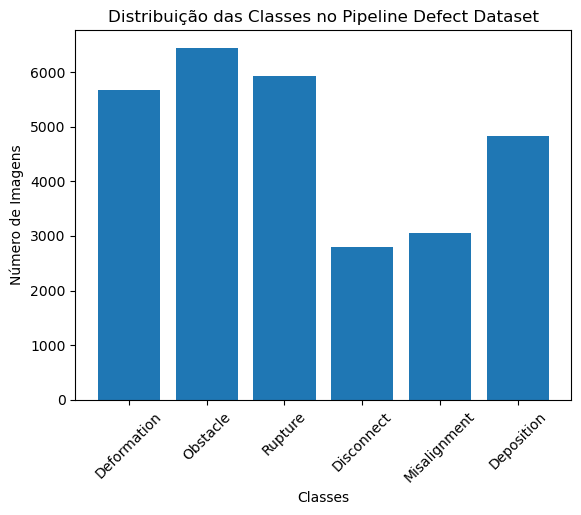

Deformation: 5676 imagens
Obstacle: 6441 imagens
Rupture: 5933 imagens
Disconnect: 2804 imagens
Misalignment: 3056 imagens
Deposition: 4820 imagens


In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np

# Caminho para os arquivos de labels
labels_path = r'C:\Users\lidia\OneDrive\Área de Trabalho\Mestrado\Visão Computacional\pipeline_dataset\labels\labels\train'

# Inicializar contadores para as classes
class_counts = np.zeros(6, dtype=int)

# Percorrer todos os arquivos de labels
for label_file in os.listdir(labels_path):
    file_path = os.path.join(labels_path, label_file)
    with open(file_path, 'r') as file:
        for line in file:
            class_index = int(line.split()[0])  # Pegar o índice da classe
            class_counts[class_index] += 1

# Nomes das classes
class_names = ['Deformation', 'Obstacle', 'Rupture', 'Disconnect', 'Misalignment', 'Deposition']

# Plotar o gráfico de barras
plt.bar(class_names, class_counts)
plt.xlabel('Classes')
plt.ylabel('Número de Imagens')
plt.title('Distribuição das Classes no Pipeline Defect Dataset')
plt.xticks(rotation=45)
plt.show()

# Exibir contagem por classe
for i, count in enumerate(class_counts):
    print(f"{class_names[i]}: {count} imagens")


In [27]:
# Relatório de classificação
from sklearn.metrics import classification_report
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step
              precision    recall  f1-score   support

       False       0.81      0.95      0.88      2701
        True       0.20      0.05      0.08       617

    accuracy                           0.79      3318
   macro avg       0.51      0.50      0.48      3318
weighted avg       0.70      0.79      0.73      3318



In [25]:
import os
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
import matplotlib.pyplot as plt

# Definir parâmetros diretamente
batch_size = 8
epochs = 20
learning_rate = 0.0001
metrics = ["accuracy", "Precision", "Recall"]

# Caminhos
images_path = r'Defect-detection-in-pipelines/images/images/train'
labels_path = r'Defect-detection-in-pipelines/labels/labels/train'

# Função para carregar e processar imagens
def load_and_process_images(images_path, labels_path, img_size=(256, 256)):
    image_files = os.listdir(images_path)
    images, labels = [], []

    for image_file in image_files:
        img = Image.open(os.path.join(images_path, image_file)).resize(img_size)
        img = np.array(img, dtype=np.float32) / 255.0
        
        label_file = image_file.replace('.jpg', '.txt')
        with open(os.path.join(labels_path, label_file), 'r') as f:
            label = int(f.readline().split()[0]) == 2  # Classe "Rupture" = 1, outros = 0

        images.append(img)
        labels.append(label)
    
    return np.array(images), np.array(labels)

# Carregar dados
X, y = load_and_process_images(images_path, labels_path)

# Divisão dos dados
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Data Augmentation
train_datagen = ImageDataGenerator(horizontal_flip=True, rotation_range=20, width_shift_range=0.1, height_shift_range=0.1)
val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

# Modelo CNN atualizado
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.5),

    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(1, activation='sigmoid')
])

# Compilação
model.compile(optimizer=Adam(learning_rate=learning_rate), 
              loss=BinaryCrossentropy(), 
              metrics=metrics)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Treinamento
history = model.fit(train_generator, validation_data=val_generator, epochs=epochs, callbacks=[early_stopping])

# Avaliação no conjunto de teste
test_generator = val_datagen.flow(X_test, y_test, batch_size=batch_size)
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Exibir curvas de aprendizado
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Epoch 1/20


/opt/conda/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/conda/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1936/1936 ━━━━━━━━━━━━━━━━━━━━ 269s 138ms/step - Precision: 0.2127 - Recall: 0.3712 - accuracy: 0.6234 - loss: 0.7475 - val_Precision: 0.2184 - val_Recall: 0.0728 - val_accuracy: 0.7788 - val_loss: 1.3112
Epoch 2/20
1936/1936 ━━━━━━━━━━━━━━━━━━━━ 440s 227ms/step - Precision: 0.2955 - Recall: 0.1589 - accuracy: 0.7770 - loss: 0.5259 - val_Precision: 0.2843 - val_Recall: 0.0906 - val_accuracy: 0.7881 - val_loss: 0.6110
Epoch 3/20
1936/1936 ━━━━━━━━━━━━━━━━━━━━ 418s 216ms/step - Precision: 0.2601 - Recall: 0.1418 - accuracy: 0.7649 - loss: 0.5463 - val_Precision: 0.2224 - val_Recall: 0.2540 - val_accuracy: 0.6956 - val_loss: 1.6328
Epoch 4/20
1936/1936 ━━━━━━━━━━━━━━━━━━━━ 410s 212ms/step - Precision: 0.2959 - Recall: 0.1275 - accuracy: 0.7763 - loss: 0.5357 - val_Precision: 0.2186 - val_Recall: 0.3317 - val_accuracy: 0.6546 - val_loss: 1.9045
Epoch 5/20
1936/1936 ━━━━━━━━━━━━━━━━━━━━ 454s 234ms/step - Precision: 0.3014 - Recall: 0.1173 - accuracy: 0.7849 - loss: 0.5045 - val_Precision: 0

ValueError: too many values to unpack (expected 2)

In [26]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y),
    y=y
)
print(f"Class weights: {dict(enumerate(class_weights))}")



Class weights: {0: np.float64(0.614307931570762), 1: np.float64(2.687074829931973)}


In [29]:
import os
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K

# Função para calcular F1-Score diretamente como métrica
def f1_score_metric(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')  # Garantir que y_true seja float32
    y_pred = K.cast(y_pred, 'float32')  # Garantir que y_pred seja float32
    return K.mean(2 * (y_true * y_pred) / (y_true + y_pred + K.epsilon()))

# Caminhos
images_path = r'Defect-detection-in-pipelines/images/images/train'
labels_path = r'Defect-detection-in-pipelines/labels/labels/train'

# Função para carregar e processar imagens
def load_and_process_images(images_path, labels_path, img_size=(256, 256)):
    image_files = os.listdir(images_path)
    images, labels = [], []

    for image_file in image_files:
        img = Image.open(os.path.join(images_path, image_file)).resize(img_size)
        img = np.array(img, dtype=np.float32) / 255.0
        
        label_file = image_file.replace('.jpg', '.txt')
        with open(os.path.join(labels_path, label_file), 'r') as f:
            label = int(f.readline().split()[0]) == 2  # Classe "Rupture" = 1, outros = 0

        images.append(img)
        labels.append(label)
    
    return np.array(images), np.array(labels)

# Carregar dados
X, y = load_and_process_images(images_path, labels_path)

# Divisão dos dados
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Data Augmentation
train_datagen = ImageDataGenerator(horizontal_flip=True, rotation_range=20, width_shift_range=0.1, height_shift_range=0.1)
val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)  # Ajuste para batch_size fixo
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

# Modelo CNN atualizado
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.5),

    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(1, activation='sigmoid')
])

# Compilação
model.compile(optimizer=Adam(learning_rate=0.0001), loss=BinaryCrossentropy(), 
              metrics=['accuracy', 'Precision', 'Recall', f1_score_metric])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
callbacks = [early_stopping]

# Treinamento
model.fit(train_generator, validation_data=val_generator, epochs=20, callbacks=callbacks)

# Avaliação no conjunto de teste
test_metrics = model.evaluate(val_generator)

# Exibindo os valores das métricas
print(f"Test Loss: {test_metrics[0]}")
print(f"Test Accuracy: {test_metrics[1]}")
print(f"Test Precision: {test_metrics[2]}")
print(f"Test Recall: {test_metrics[3]}")
print(f"Test F1-Score: {test_metrics[4]}")

/opt/conda/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/conda/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
484/484 ━━━━━━━━━━━━━━━━━━━━ 179s 363ms/step - Precision: 0.2294 - Recall: 0.5338 - accuracy: 0.5813 - f1_score_metric: 0.1050 - loss: 0.8707 - val_Precision: 0.1585 - val_Recall: 0.0631 - val_accuracy: 0.7631 - val_f1_score_metric: 0.0325 - val_loss: 1.2998
Epoch 2/20
484/484 ━━━━━━━━━━━━━━━━━━━━ 186s 384ms/step - Precision: 0.2672 - Recall: 0.3376 - accuracy: 0.7020 - f1_score_metric: 0.0853 - loss: 0.6159 - val_Precision: 0.1885 - val_Recall: 0.3608 - val_accuracy: 0.5916 - val_f1_score_metric: 0.0798 - val_loss: 3.2923
Epoch 3/20
484/484 ━━━━━━━━━━━━━━━━━━━━ 169s 350ms/step - Precision: 0.2927 - Recall: 0.2115 - accuracy: 0.7579 - f1_score_metric: 0.0675 - loss: 0.5409 - val_Precision: 0.1761 - val_Recall: 0.1359 - val_accuracy: 0.7206 - val_f1_score_metric: 0.0455 - val_loss: 2.5603
Epoch 4/20
484/484 ━━━━━━━━━━━━━━━━━━━━ 176s 364ms/step - Precision: 0.3468 - Recall: 0.1697 - accuracy: 0.7831 - f1_score_metric: 0.0596 - loss: 0.5097 - val_Precision: 0.1768 - val_Recall: